<div style="font-size: 16px;"><strong>
    CONCLUSION: We pick the model generated by epoch 4 because it has the lowest validation loss and highest validation accuracy!
</strong></div>

In [2]:
!pip install pydicom -q
!pip uninstall torch torchvision -y
!pip install torch==2.1 torchvision==0.16 -q
!pip install -qU pycocotools
!pip install -qU wandb

# Configs

In [3]:
for name in list(globals()):
    if not name.startswith("_"):  # Avoid deleting built-in and special variables
        del globals()[name]

In [4]:
CONDITION = 'SpinalCanalStenosis'

## Load libraries

In [5]:
import os
import time
from datetime import datetime
import numpy as np
import collections
import random
import torch

from matplotlib import animation, rc
import pandas as pd

import matplotlib.pyplot as plt

## Reproducibility

In [6]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Directories

In [7]:
PROJECT_DIR = '/home/jupyter'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
SRC_DIR = os.path.join(PROJECT_DIR, 'src')
CROP_DIR = os.path.join(DATA_DIR, 'train_crops', '02_train_disc_detection', CONDITION)
os.makedirs(CROP_DIR, exist_ok=True)
MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '04_train_severity_classification', CONDITION)
os.makedirs(MODEL_DIR, exist_ok=True)

## Functions

In [8]:
with open(os.path.join(SRC_DIR, 'pipeline_severity_classification.py')) as file:
    exec(file.read())

## Hyperparameters

In [9]:
CONFIG = dict(
    num_epochs=6,
    batch_size=50,
    lr=0.0001,
    lr_step_size=3,
    lr_gamma=0.1
)

## Metadata

In [10]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'val.csv'))

<div style="font-size: 16px;">
    Add the cropped image path to metadata:
</div>

In [11]:
LABELS_DICT = {
    1: "L1_L2",
    2: "L2_L3",
    3: "L3_L4",
    4: "L4_L5",
    5: "L5_S1"
}

In [12]:
def get_cropped_image_path(row):
    return f"{CROP_DIR}/{row['study_id']}/{row['series_id']}/{LABELS_DICT[row['level_code']]}/{row['instance_number']}.pt"

train_df['cropped_image_path'] = [get_cropped_image_path(row) for i, row in train_df.iterrows()]
val_df['cropped_image_path']   = [get_cropped_image_path(row) for i, row in val_df.iterrows()]

## Some example cropped images

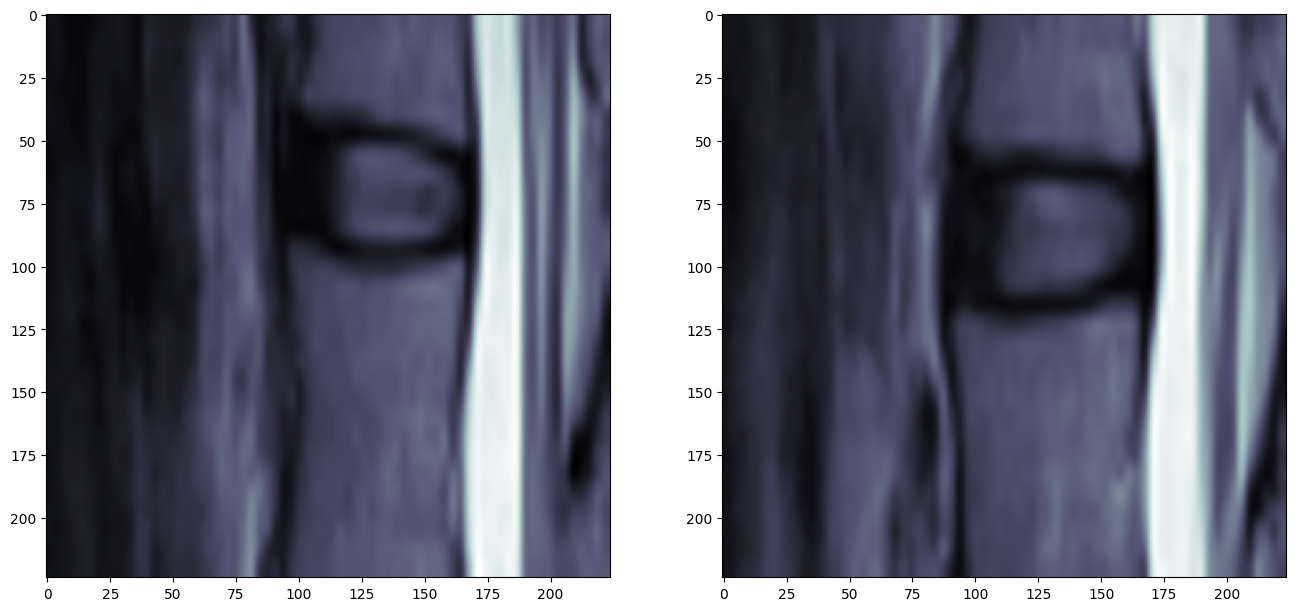

In [13]:
tmp_ds = RSNACroppedImageDataset(train_df)
tmp_dl = torch.utils.data.DataLoader(
  tmp_ds,
  batch_size=1,
  shuffle=False
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
for i, (img, label) in enumerate(tmp_dl):
    if i == 2: break
    y = img[0][0].numpy()
    ax[i].imshow(y, cmap=plt.cm.bone)
del tmp_ds, tmp_dl

# Training

## Load Model

In [14]:
model = load_model_severity_classification()

In [15]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model: {count_trainable_parameters(model)}")

Number of trainable parameters in the model: 27584877


## Test forward

In [16]:
# Create dataset and dataloader
dataset = RSNACroppedImageDataset(train_df)
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=1,
  shuffle=True
)

In [17]:
# Get first input from dataloader
images, labels = next(iter(data_loader))

# Inference
model.to('cpu')
model.eval()
with torch.inference_mode():
    predictions = model(images)

In [18]:
print(f"Predicted values for 3 classes in one sample: {predictions.squeeze().tolist()}")

Predicted values for 3 classes in one sample: [-0.0005474034696817398, -0.06372404843568802, -0.12209618091583252]


## Train and validate

In [19]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()
# !nvidia-smi

In [20]:
model_pipeline(config=CONFIG, model=model, model_dir=MODEL_DIR, train_df=train_df, val_df=val_df, device=device, limit=None)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ning-shen (ning-shen-university-of-british-columbia). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.6
wandb: Run data is saved locally in /home/jupyter/notebooks/wandb/run-20241112_092731-6x9a80wb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dry-resonance-29
wandb: ⭐️ View project at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: 🚀 View run at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/6x9a80wb
  0%|          | 0/6 [00:00<?, ?it/s]

Loss after 00950 examples: 0.971
Batch 20 Metrics:
  Accuracy: 85.89%
  Class 0: Precision: 0.8773, Recall: 0.9760, F1-score: 0.9240
  Class 1: Precision: 0.0476, Recall: 0.0154, F1-score: 0.0233
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 01950 examples: 0.813
Batch 40 Metrics:
  Accuracy: 87.10%
  Class 0: Precision: 0.8710, Recall: 1.0000, F1-score: 0.9311
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 02950 examples: 0.686
Batch 60 Metrics:
  Accuracy: 88.90%
  Class 0: Precision: 0.8890, Recall: 1.0000, F1-score: 0.9412
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 03950 examples: 0.664
Batch 80 Metrics:
  Accuracy: 87.20%
  Class 0: Precision: 0.8720, Recall: 1.0000, F1-score: 0.9316
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.0000, F1

 17%|█▋        | 1/6 [11:49<59:06, 709.38s/it]

Validation Metrics:
  Loss: 0.5534
  Accuracy: 82.49%
  Class 0: Precision: 0.9462, Recall: 0.9036, F1-score: 0.9244
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.2098, Recall: 0.7414, F1-score: 0.3270
Loss after 07995 examples: 0.754
Batch 20 Metrics:
  Accuracy: 81.26%
  Class 0: Precision: 0.9434, Recall: 0.8885, F1-score: 0.9151
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.2254, Recall: 0.7647, F1-score: 0.3482
Loss after 08995 examples: 0.508
Batch 40 Metrics:
  Accuracy: 86.70%
  Class 0: Precision: 0.9501, Recall: 0.9394, F1-score: 0.9447
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.2521, Recall: 0.6977, F1-score: 0.3704
Loss after 09995 examples: 0.401
Batch 60 Metrics:
  Accuracy: 83.70%
  Class 0: Precision: 0.9322, Recall: 0.9247, F1-score: 0.9284
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.2708, Recall: 0.6964, F1-score:

 33%|███▎      | 2/6 [17:03<31:48, 477.12s/it]

Validation Metrics:
  Loss: 0.4004
  Accuracy: 88.76%
  Class 0: Precision: 0.9618, Recall: 0.9486, F1-score: 0.9552
  Class 1: Precision: 0.4894, Recall: 0.2347, F1-score: 0.3172
  Class 2: Precision: 0.3952, Recall: 0.8448, F1-score: 0.5385
Loss after 15040 examples: 0.794
Batch 20 Metrics:
  Accuracy: 89.37%
  Class 0: Precision: 0.9428, Recall: 0.9711, F1-score: 0.9567
  Class 1: Precision: 0.5833, Recall: 0.0986, F1-score: 0.1687
  Class 2: Precision: 0.4268, Recall: 0.7292, F1-score: 0.5385
Loss after 16040 examples: 0.500
Batch 40 Metrics:
  Accuracy: 88.40%
  Class 0: Precision: 0.9546, Recall: 0.9481, F1-score: 0.9514
  Class 1: Precision: 0.2273, Recall: 0.0725, F1-score: 0.1099
  Class 2: Precision: 0.3918, Recall: 0.8636, F1-score: 0.5390
Loss after 17040 examples: 0.266
Batch 60 Metrics:
  Accuracy: 90.50%
  Class 0: Precision: 0.9619, Recall: 0.9795, F1-score: 0.9706
  Class 1: Precision: 0.5000, Recall: 0.0811, F1-score: 0.1395
  Class 2: Precision: 0.4271, Recall: 0.820

 50%|█████     | 3/6 [19:33<16:22, 327.65s/it]

Validation Metrics:
  Loss: 0.3394
  Accuracy: 89.64%
  Class 0: Precision: 0.9552, Recall: 0.9587, F1-score: 0.9569
  Class 1: Precision: 0.4259, Recall: 0.2347, F1-score: 0.3026
  Class 2: Precision: 0.5000, Recall: 0.8448, F1-score: 0.6282
Loss after 22085 examples: 0.317
Batch 20 Metrics:
  Accuracy: 90.32%
  Class 0: Precision: 0.9625, Recall: 0.9636, F1-score: 0.9631
  Class 1: Precision: 0.5000, Recall: 0.3077, F1-score: 0.3810
  Class 2: Precision: 0.5132, Recall: 0.8298, F1-score: 0.6341
Loss after 23085 examples: 0.234
Batch 40 Metrics:
  Accuracy: 94.10%
  Class 0: Precision: 0.9775, Recall: 0.9742, F1-score: 0.9759
  Class 1: Precision: 0.5652, Recall: 0.4483, F1-score: 0.5000
  Class 2: Precision: 0.7031, Recall: 0.9184, F1-score: 0.7965
Loss after 24085 examples: 0.485
Batch 60 Metrics:
  Accuracy: 91.20%
  Class 0: Precision: 0.9734, Recall: 0.9557, F1-score: 0.9645
  Class 1: Precision: 0.4444, Recall: 0.3944, F1-score: 0.4179
  Class 2: Precision: 0.5833, Recall: 0.875

 67%|██████▋   | 4/6 [22:02<08:34, 257.02s/it]

Validation Metrics:
  Loss: 0.3150
  Accuracy: 90.12%
  Class 0: Precision: 0.9637, Recall: 0.9495, F1-score: 0.9565
  Class 1: Precision: 0.4409, Recall: 0.4184, F1-score: 0.4293
  Class 2: Precision: 0.5949, Recall: 0.8103, F1-score: 0.6861
Loss after 29130 examples: 0.155
Batch 20 Metrics:
  Accuracy: 92.21%
  Class 0: Precision: 0.9803, Recall: 0.9568, F1-score: 0.9684
  Class 1: Precision: 0.5294, Recall: 0.6000, F1-score: 0.5625
  Class 2: Precision: 0.6538, Recall: 0.8095, F1-score: 0.7234
Loss after 30130 examples: 0.291
Batch 40 Metrics:
  Accuracy: 91.70%
  Class 0: Precision: 0.9695, Recall: 0.9538, F1-score: 0.9616
  Class 1: Precision: 0.5065, Recall: 0.4937, F1-score: 0.5000
  Class 2: Precision: 0.7324, Recall: 0.9455, F1-score: 0.8254
Loss after 31130 examples: 0.179
Batch 60 Metrics:
  Accuracy: 94.10%
  Class 0: Precision: 0.9841, Recall: 0.9752, F1-score: 0.9796
  Class 1: Precision: 0.6066, Recall: 0.5692, F1-score: 0.5873
  Class 2: Precision: 0.6500, Recall: 0.812

 83%|████████▎ | 5/6 [24:30<03:37, 217.85s/it]

Validation Metrics:
  Loss: 0.3215
  Accuracy: 89.96%
  Class 0: Precision: 0.9708, Recall: 0.9467, F1-score: 0.9586
  Class 1: Precision: 0.4457, Recall: 0.4184, F1-score: 0.4316
  Class 2: Precision: 0.5275, Recall: 0.8276, F1-score: 0.6443
Loss after 36175 examples: 0.206
Batch 20 Metrics:
  Accuracy: 93.79%
  Class 0: Precision: 0.9853, Recall: 0.9675, F1-score: 0.9763
  Class 1: Precision: 0.5974, Recall: 0.6479, F1-score: 0.6216
  Class 2: Precision: 0.7241, Recall: 0.8571, F1-score: 0.7850
Loss after 37175 examples: 0.121
Batch 40 Metrics:
  Accuracy: 92.00%
  Class 0: Precision: 0.9745, Recall: 0.9578, F1-score: 0.9661
  Class 1: Precision: 0.5385, Recall: 0.5250, F1-score: 0.5316
  Class 2: Precision: 0.6333, Recall: 0.8837, F1-score: 0.7379
Loss after 38175 examples: 0.387
Batch 60 Metrics:
  Accuracy: 93.50%
  Class 0: Precision: 0.9839, Recall: 0.9595, F1-score: 0.9715
  Class 1: Precision: 0.5775, Recall: 0.5942, F1-score: 0.5857
  Class 2: Precision: 0.6613, Recall: 0.976

100%|██████████| 6/6 [26:59<00:00, 269.84s/it]

Validation Metrics:
  Loss: 0.3477
  Accuracy: 89.64%
  Class 0: Precision: 0.9734, Recall: 0.9421, F1-score: 0.9575
  Class 1: Precision: 0.4598, Recall: 0.4082, F1-score: 0.4324
  Class 2: Precision: 0.4808, Recall: 0.8621, F1-score: 0.6173



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▄▄▅▄▄▄▅▁▄▂▄▄▅▅▅▅▆▄▅▅▆█▆▇▇▇▆▇▇█▇▇▇▇█▇█▇▇█
wandb:         epoch ▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
wandb:          loss █▇▆▆▇▄▃▆▄▃▃▅▃▅▇▄▂▂▄▄▃▂▄▃▄▁▂▁▂▂▅▁▂▂▂▁▃▁▁▂
wandb: test_accuracy ▁▇████
wandb:     test_loss █▄▂▁▁▂
wandb: 
wandb: Run summary:
wandb:      accuracy 0.934
wandb:         epoch 5
wandb:          loss 0.18316
wandb: test_accuracy 0.89639
wandb:     test_loss 0.34766
wandb: 
wandb: 🚀 View run dry-resonance-29 at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/6x9a80wb
wandb: ⭐️ View project at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20241112_092731-6x9a80wb/logs


<div style="font-size: 16px;"><strong>
    CONCLUSION: We pick the model generated by epoch 4 because it has the lowest validation loss and highest validation accuracy!
</strong></div>